In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

dataset_names = !cat NCI60/names
dataset = dataset_names[3]
dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
print 'Working with dataset: %s' % dataset 

#dataset_fname = 'bursi.pos.gspan'

Working with dataset: HOP_92_t


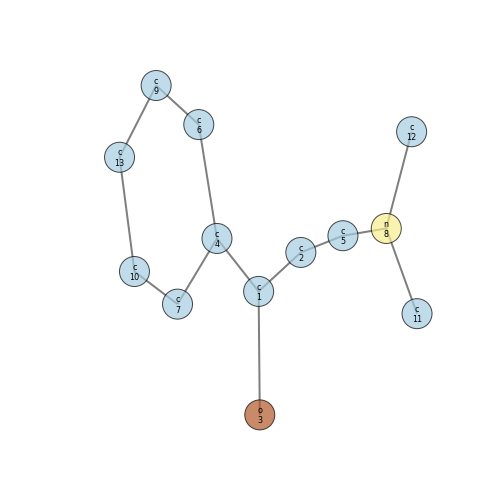

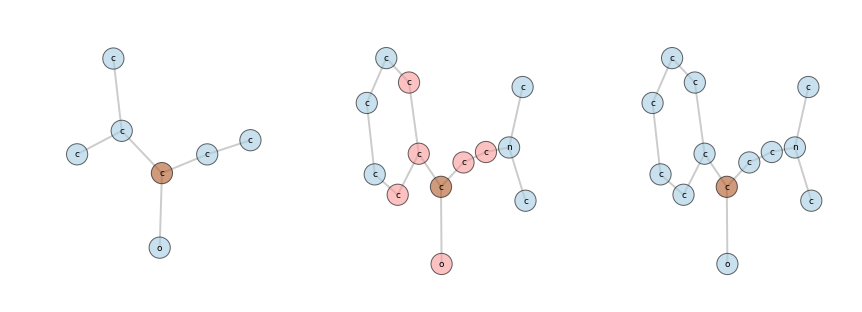

In [61]:
'''
first we test the core/interface extractor, since it is most essential
'''
from graphlearn.utils.draw import display, cip_to_graph, draw_graph_set_graphlearn
from graphlearn.graphtools import extract_core_and_interface

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = get_graphs(dataset_fname)
graph = next(graphs)
display(graph, size=8, font_size=8, secondary_vertex_label='ID',
        colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
        vertex_alpha=0.7, node_size=900)

radius_list=[0,2]
thickness_list=[2,4]
cip=extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
graph=cip_to_graph(cip)
draw_graph_set_graphlearn(graph,
                          n_graphs_per_line=7, size=5, 
                          colormap='Paired', invert_colormap=False,node_border=1,
                          vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

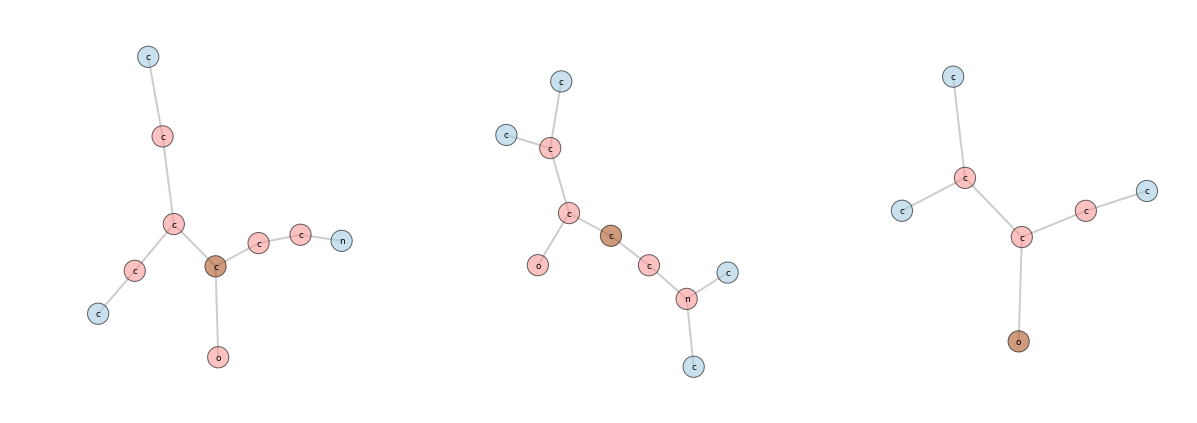

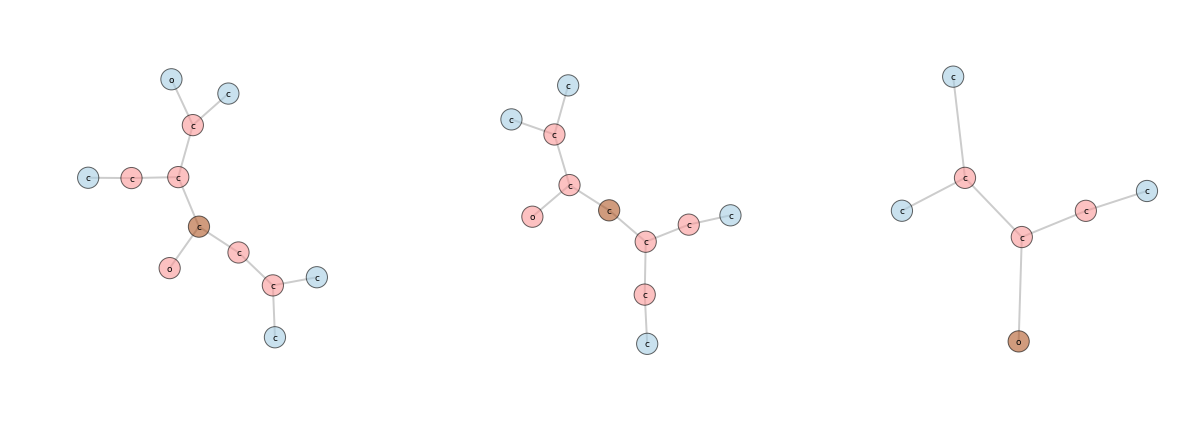

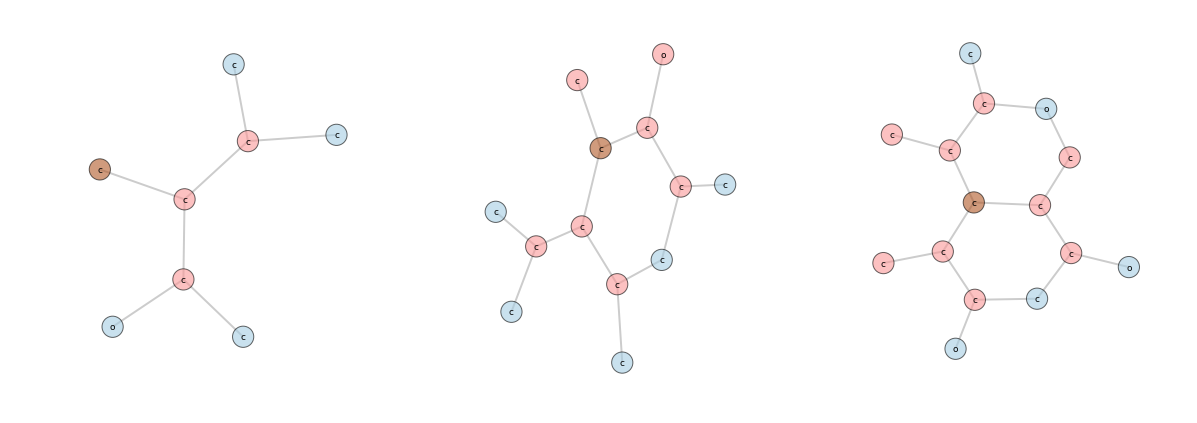

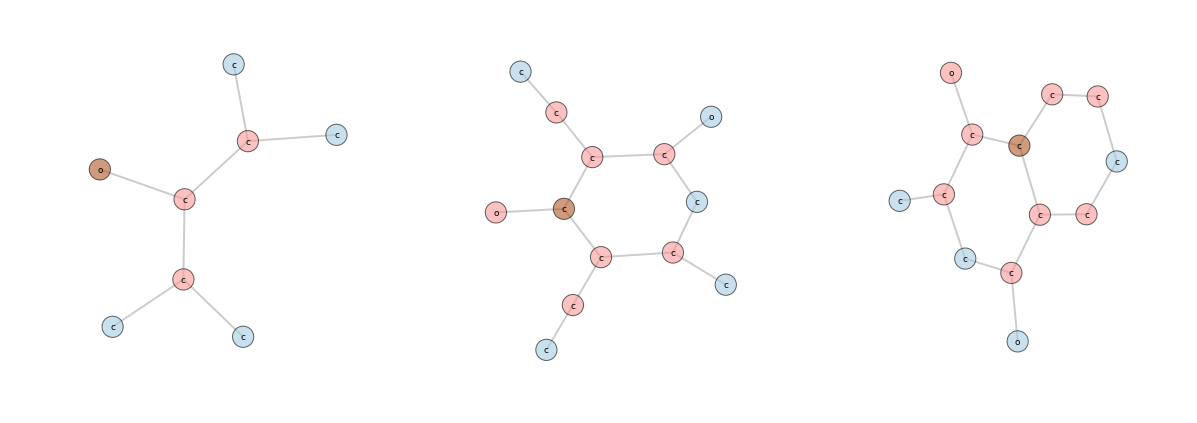

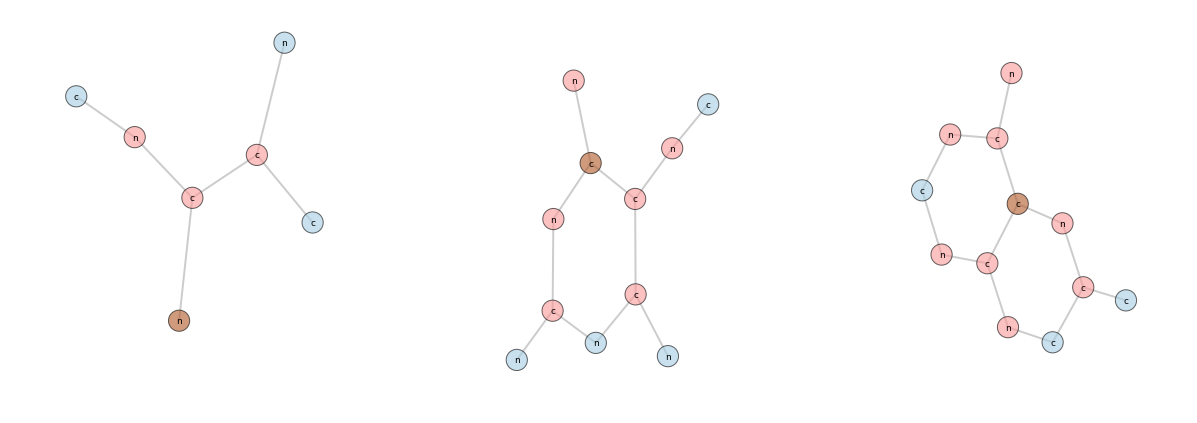

In [62]:
'''
demonstrating more extract core
'''
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.utils.draw import draw_graph_set_graphlearn, cip_to_graph
from graphlearn.graphtools import extract_core_and_interface
from eden.graph import Vectorizer

graphs = get_graphs(dataset_fname, size=5)
for graph in graphs:
    graphs_list=[]
    for node in range(1,4):
        cips = extract_core_and_interface(node,graph,radius_list=[2],thickness_list=[1],vectorizer=Vectorizer())
        # draw cip on the original graph and save in nice_graphs
        cip_graphs = cip_to_graph(cips)
        for g,c in zip(cip_graphs,cips):
            g.graph['info'] = str(c.interface_hash)
        graphs_list += cip_graphs
    # draw marked graphs
    draw_graph_set_graphlearn(graphs_list, contract=False,
                              n_graphs_per_line=5, size=7, colormap='Paired', invert_colormap=False,node_border=1,
                              vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

In [63]:
%%time
'''
induce a grammar and train an estimator
'''
from graphlearn.graphlearn import GraphLearnSampler
training_graphs = get_graphs(dataset_fname, size=200)
sampler=GraphLearnSampler(radius_list=[1],thickness_list=[2],
                          min_cip_count=2, min_interface_count=2)
sampler.fit(training_graphs,n_jobs=-1,batch_size=10)

print('graph grammar stats:')
interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (interface_counts, core_counts, cip_counts))

/Users/costa/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/costa/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/costa/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


graph grammar stats:
#interfaces: 74   #cores: 47   #core-interface-pairs: 202
CPU times: user 16.8 s, sys: 1.62 s, total: 18.4 s
Wall time: 24.8 s


interface id: 283481 [13 options]


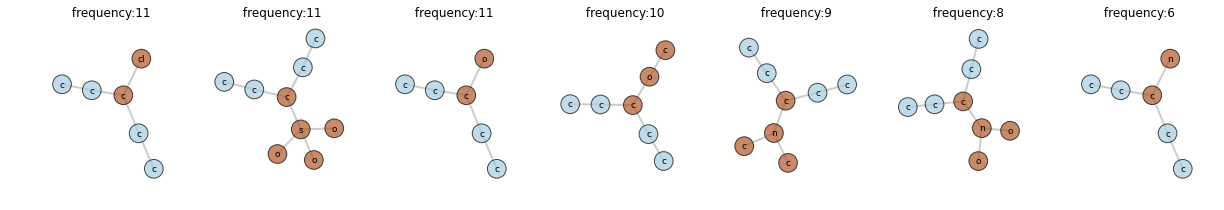

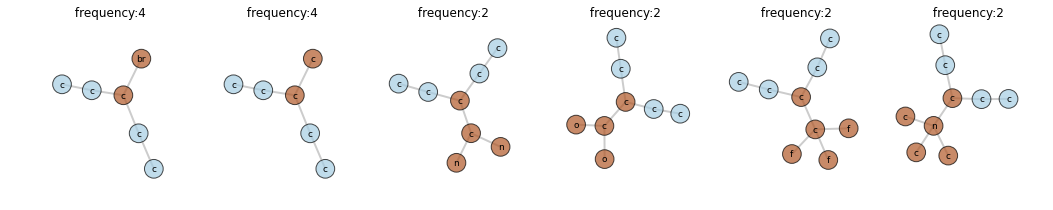

interface id: 474876 [7 options]


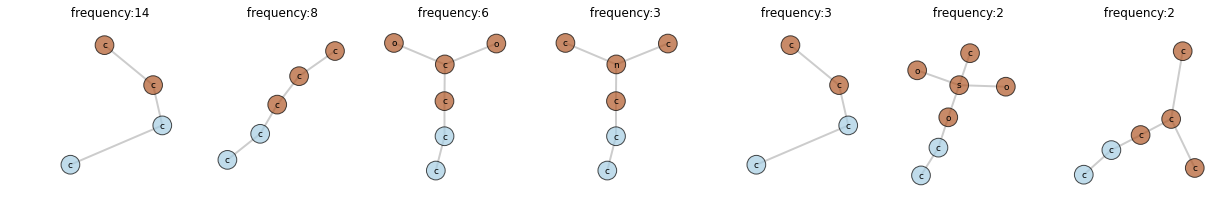

interface id: 670691 [6 options]


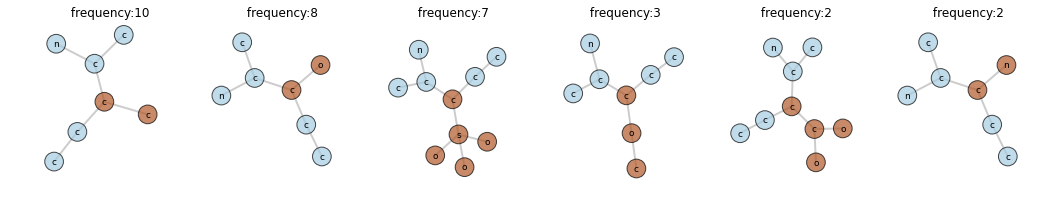

interface id: 577859 [6 options]


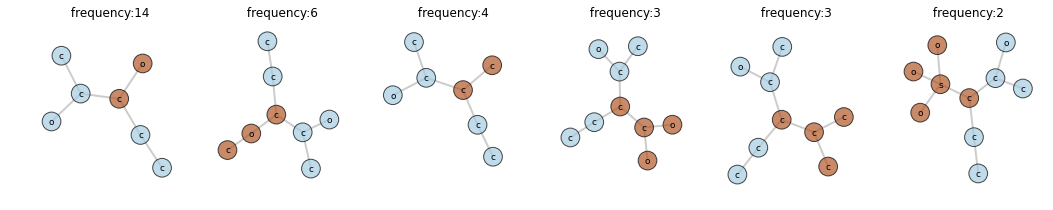

interface id: 229273 [6 options]


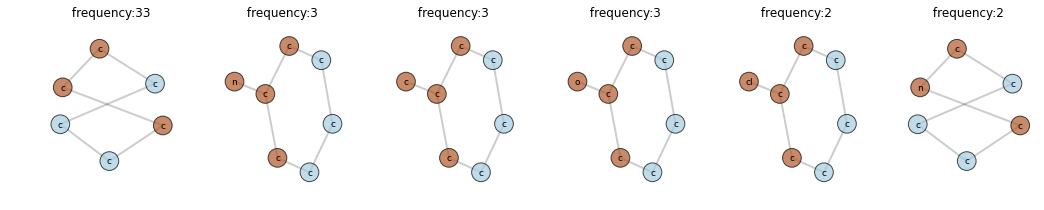

interface id: 786073 [5 options]


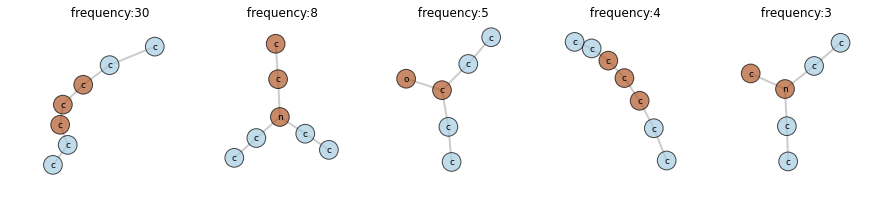

In [64]:
#draw production rules
from graphlearn.utils.draw import draw_grammar
draw_grammar(sampler.grammar().productions,
             n_productions=6,n_graphs_per_line=7, 
             size=3, colormap='Paired', node_border=1, vertex_alpha=0.7, edge_alpha=0.2, node_size=350)

how often do we see interface hashes
# productions: 202
x = # interfaces (total: 74)
y=number of cores(ihash), y=sum Of Core Counts(ihash)


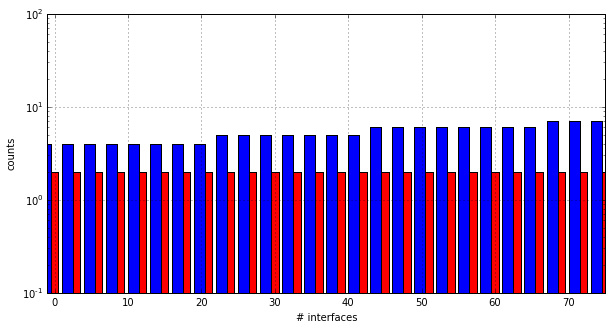

how often was this corehash seen?
x = # cores (total: 47)
y = in Y interfaces(chash), y= sum Of Count Over All Interfaces(chash)


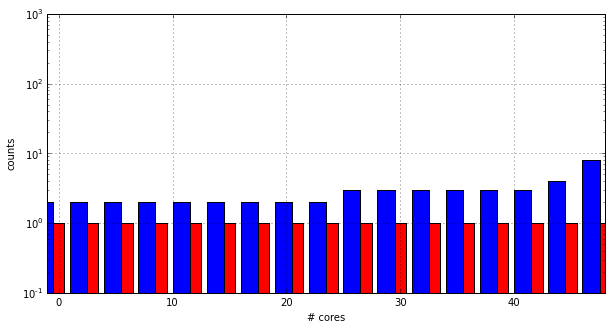

histogram
# productions: 202
distinct cores: 47 (seen on x axis)
interfaces with x many cores were observed y many times. 


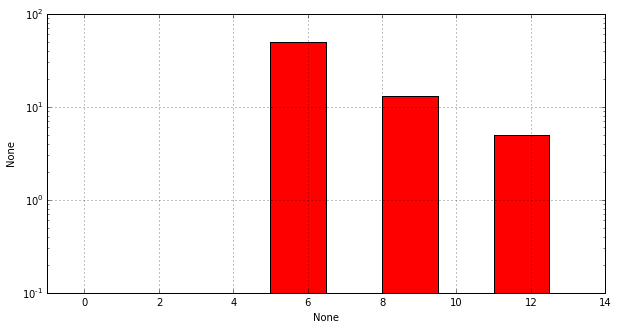

other histogram
how many cores exist with x many interfaces


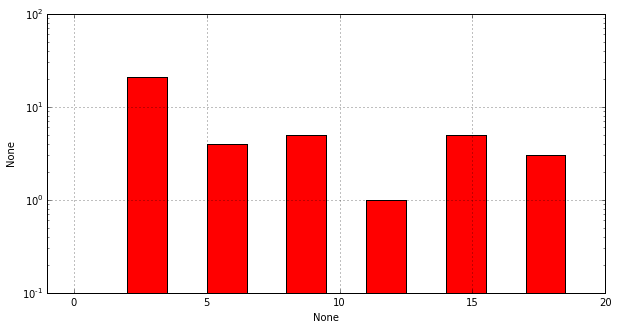

In [65]:
#grammar statistics
from graphlearn.utils.draw import draw_grammar_stats
draw_grammar_stats(sampler.grammar().productions, size=(10,5))

how often do we see interface hashes
# productions: 202
x = # interfaces (total: 74)
y=number of cores(ihash), y=sum Of Core Counts(ihash)


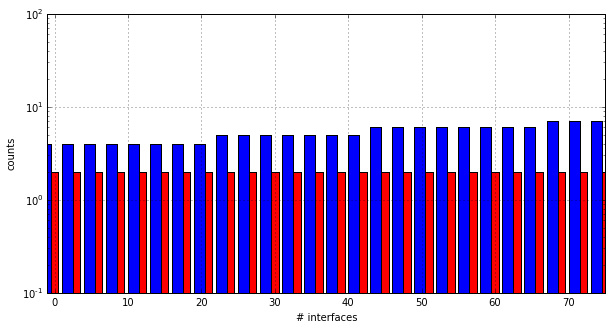

how often was this corehash seen?
x = # cores (total: 47)
y = in Y interfaces(chash), y= sum Of Count Over All Interfaces(chash)


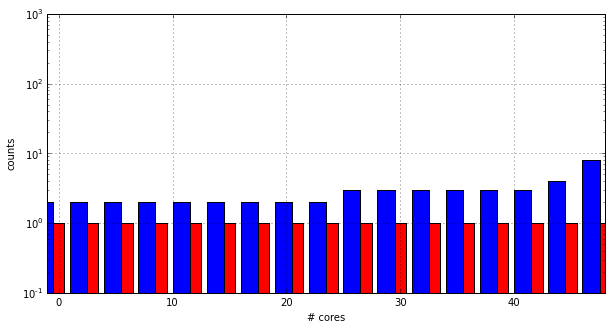

histogram
# productions: 202
distinct cores: 47 (seen on x axis)
interfaces with x many cores were observed y many times. 


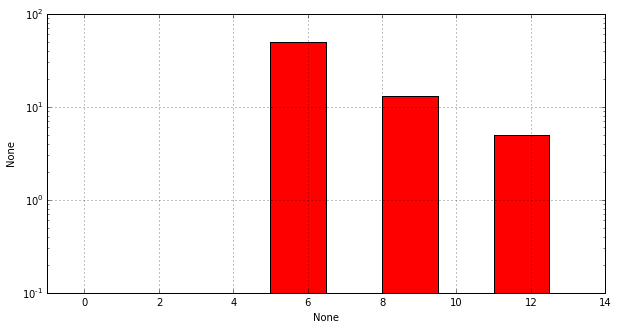

other histogram
how many cores exist with x many interfaces


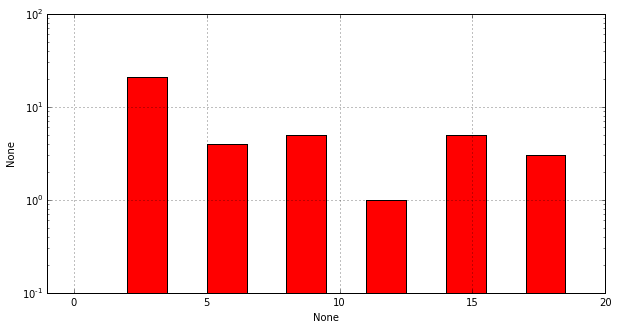

In [66]:
#grammar statistics
from graphlearn.utils.draw import draw_grammar_stats
draw_grammar_stats(sampler.grammar().productions, size=(10,5))

We work on this graph


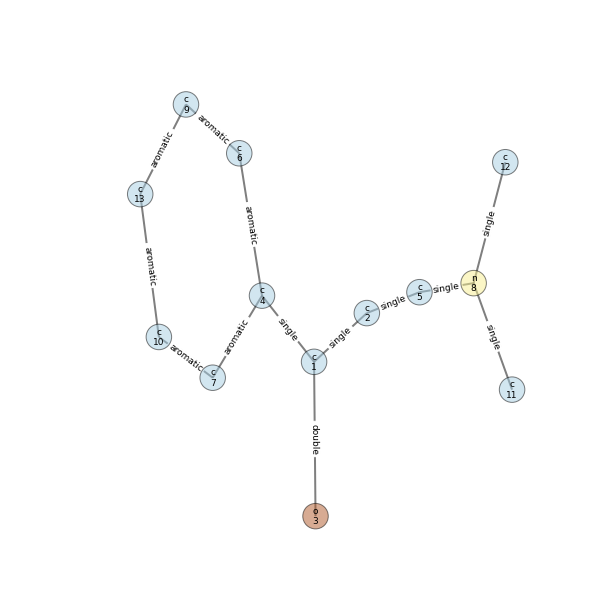

no filter


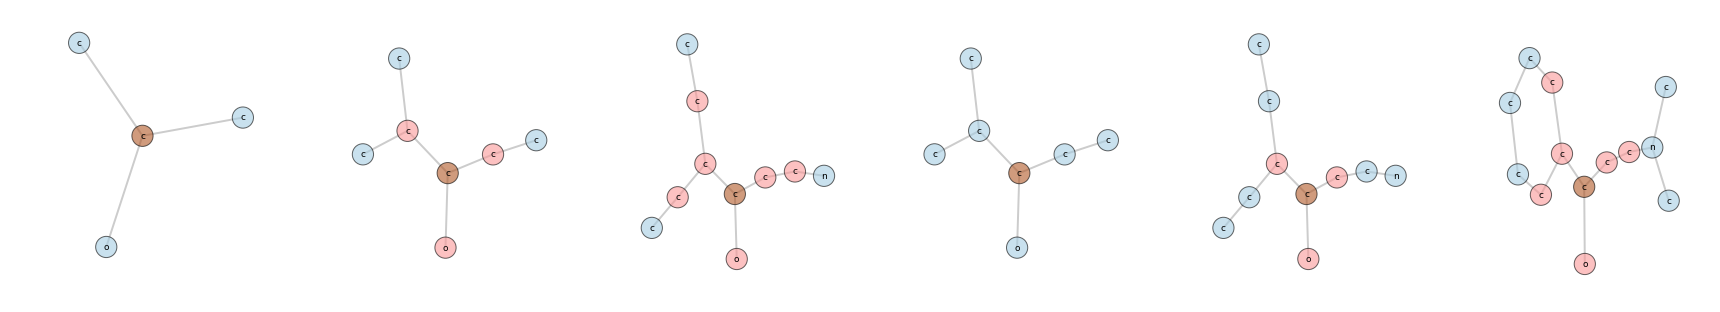

with filter: nothing should appear,,,
with filter but we chose node 2 as root


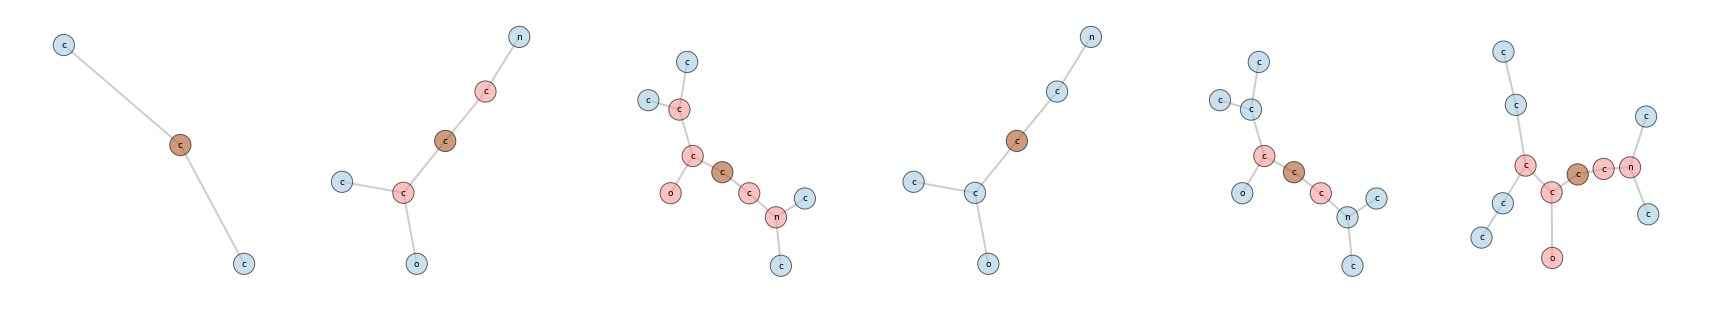

with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up


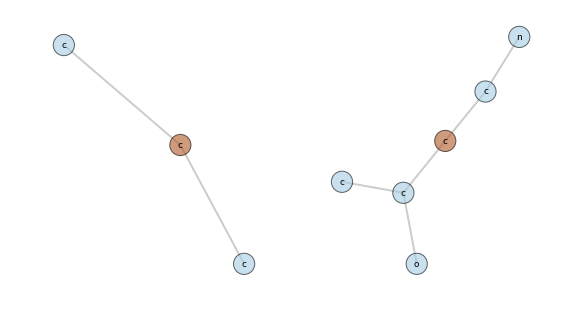

In [67]:
'''
Demonstrating the filter function
'''
#get a graph
graphs = get_graphs(dataset_fname, size=1)
graph = next(graphs)
from eden.util import display
print 'We work on this graph'
display.draw_graph(graph, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, node_size=650)

from graphlearn.utils.draw import cip_to_graph, draw_graph_set_graphlearn
def mark_and_draw(cip):
    graph=cip_to_graph(cip)
    draw_graph_set_graphlearn(graph, n_graphs_per_line=7, size=5,
                              colormap='Paired', invert_colormap=False,node_border=1,
                              vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
    
radius_list=[0,1,2]
thickness_list=[1,2]
graph.node[1]['no_root']=True
#lets see.. without filter:
from graphlearn.graphtools import extract_core_and_interface, filter
cip=extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'no filter'
mark_and_draw(cip)


# lets do the same but with the filter
cip=extract_core_and_interface(1,graph,filter=filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter: nothing should appear,,,'
mark_and_draw(cip)

# filter is ignoring unfiltered things:
cip=extract_core_and_interface(2,graph,filter=filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but we chose node 2 as root'
mark_and_draw(cip)

# no core attribute
graph.node[1]["not_in_core"]=True
graph.node[1].pop('no_root')
cip=extract_core_and_interface(2,graph,filter=filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up'
mark_and_draw(cip)

.